0
-0.1292239000952568
-0.5848152387578374
-10.64912020635914
126.61704301797968
-0.4152036934076856
-0.2983104944524224
-0.41445317950128413
-0.2984784302615364
0.20806188303974052
-0.16646431492683034
0.08803595218847296
-0.21090625378437355
1
0.3706280232695824
-0.4461436017852316
-2.2693449653180378
6.379074134525407
-0.6191041683240015
0.3697461141488887
-0.6190971402432356
0.36973537192425043
-0.16077676510555383
0.24681961258084684
-0.2942455146286453
0.3144678013338251
2
-0.4644353055417557
-0.06385555468250059
-0.8077437667150538
0.9755807032855435
-0.41601970745786077
-0.26948545244283384
-0.4159976021455704
-0.26949254401223
0.11763164660745362
-0.24584987649921386
-0.016915287125780585
-0.27043762183634934


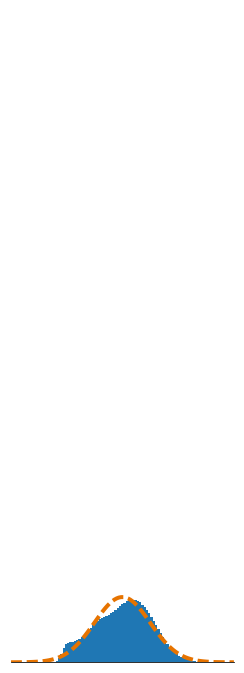

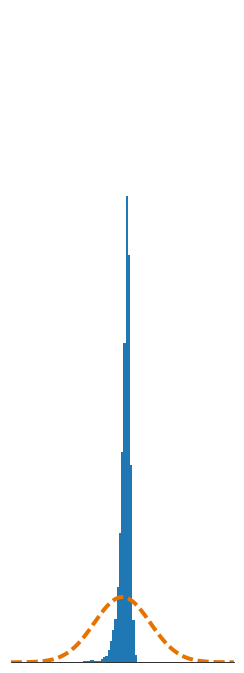

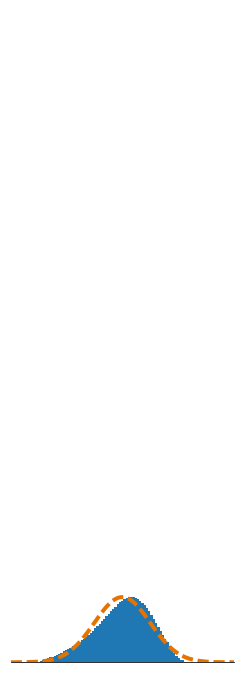

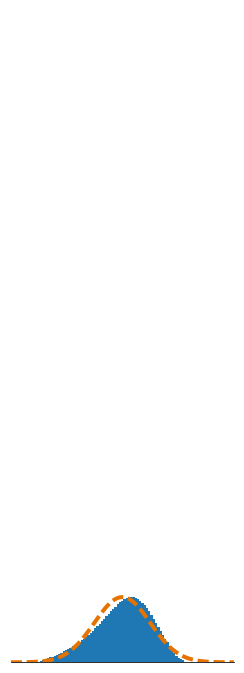

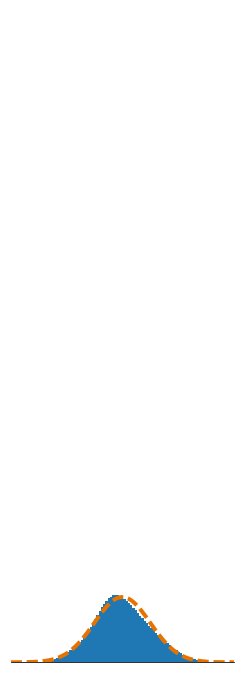

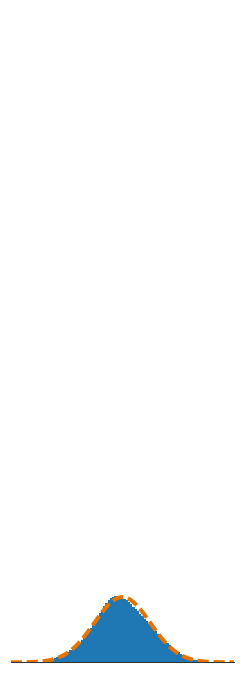

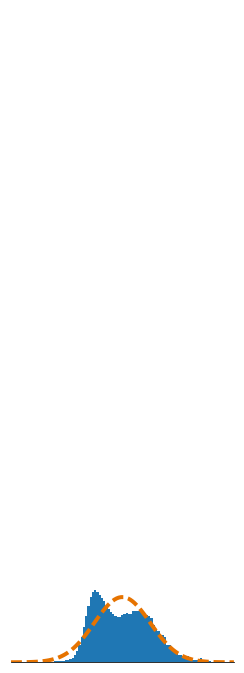

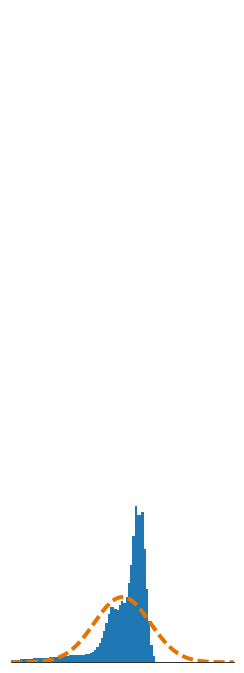

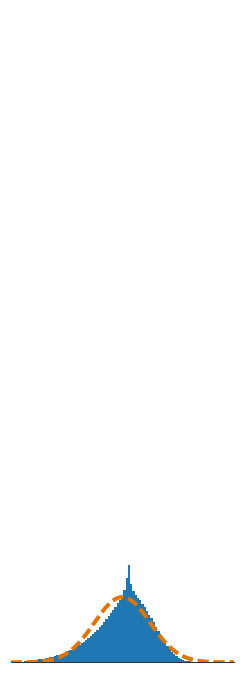

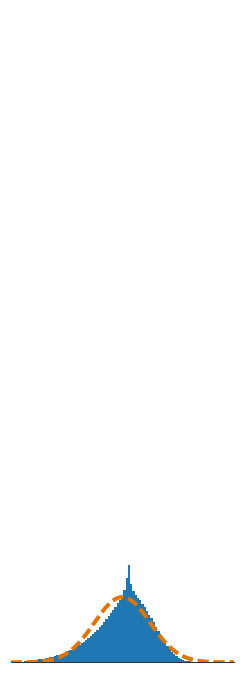

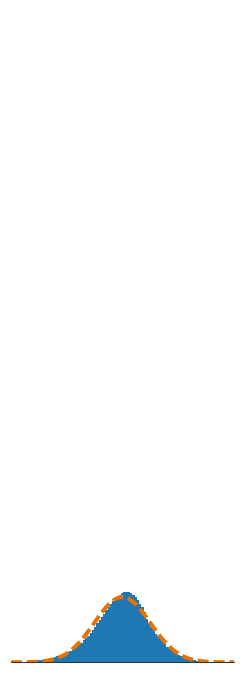

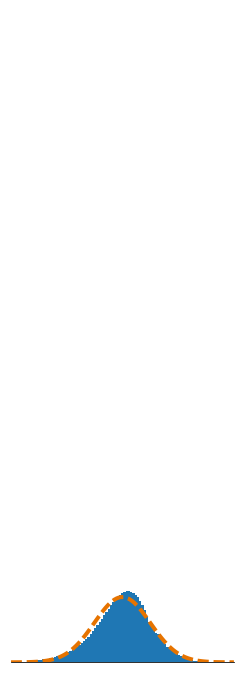

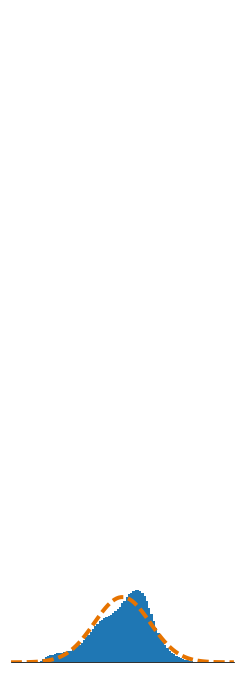

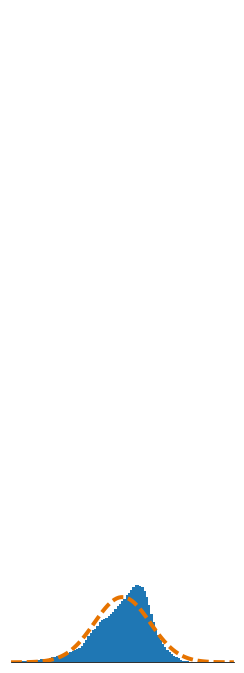

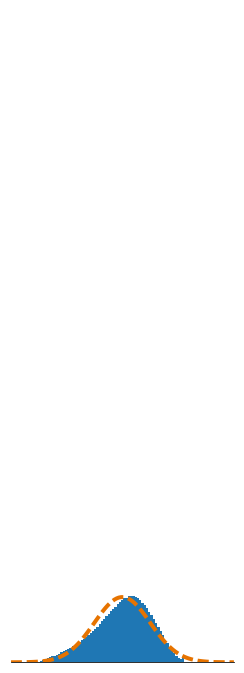

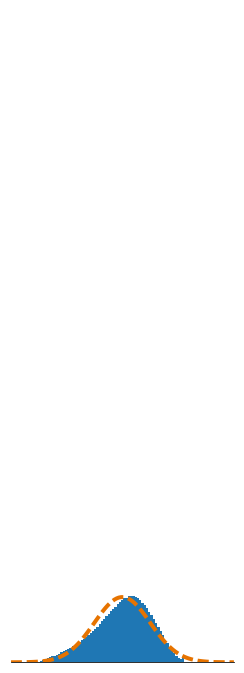

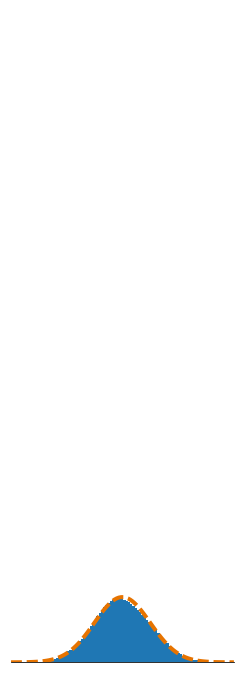

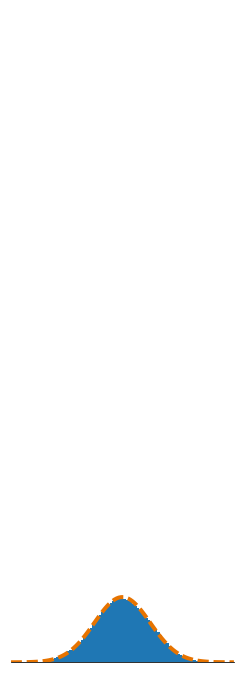

In [3]:
import glob
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy


subfolders = ["DCASE2013-pcen", "BirdVox-pcen", "SONYC-pcen"]
data_dir = '/beegfs/vl1019/spl2018_datasets'

%matplotlib inline

settings = {
    "fmin": 50,
    "fmax": 10000,
    "hop_length": 512,
    "n_fft": 2048,
    "n_mels": 128,
    "sr": 22050,
    "win_length": 1024,
    "window": "hann",
    "T": 0.023,
    "alpha": 0.96,
    "delta": 2.0,
    "r": 0.5,
    "eps": 1e-10}


figsize = (4, 12)


for subfolder_id in range(len(subfolders)):
    print(subfolder_id)
    
    
    log_E_list = []
    EoverM_list = []
    EoverMplusEps_list = []
    G_list = []
    BC_list = []
    PCEN_list = []


    subfolder_str = subfolders[subfolder_id]
    subfolder_dir = os.path.join(data_dir, subfolder_str)
    wav_names = list(glob.glob(os.path.join(subfolder_dir, "*.wav")))
    wav_paths = sorted([os.path.join(subfolder_dir, x) for x in wav_names])
    n_files = len(wav_paths)

    for file_id in range(n_files):
        wav_path = wav_paths[file_id]
        waveform, fs = librosa.load(wav_path, sr=22050)

        # Compute Short-Term Fourier Transform (STFT).
        stft = librosa.stft(
            waveform,
            n_fft=settings["n_fft"],
            win_length=settings["win_length"],
            hop_length=settings["hop_length"],
            window=settings["window"])


        # Compute squared magnitude coefficients.
        abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)


        # Gather frequency bins according to the Mel scale.
        E = librosa.feature.melspectrogram(
            y=None,
            S=abs2_stft,
            sr=settings["sr"],
            n_fft=settings["n_fft"],
            n_mels=settings["n_mels"],
            htk=True,
            fmin=settings["fmin"],
            fmax=settings["fmax"])

        EoverM = librosa.pcen(
            S=E,
            time_constant=settings["T"],
            sr=settings["sr"],
            hop_length=settings["hop_length"],
            gain=1.0,
            power=1.0,
            bias=settings["delta"],
            eps=1e-30) 
        
        EoverMplusEps = librosa.pcen(
            S=E,
            time_constant=settings["T"],
            sr=settings["sr"],
            hop_length=settings["hop_length"],
            gain=1.0,
            power=1.0,
            bias=settings["delta"],
            eps=settings["eps"]) 
        
        G = librosa.pcen(
            S=E,
            time_constant=settings["T"],
            sr=settings["sr"],
            hop_length=settings["hop_length"],
            gain=settings["alpha"],
            power=1.0,
            bias=settings["delta"],
            eps=settings["eps"])        
        
        PCEN = librosa.pcen(
            S=E,
            time_constant=settings["T"],
            sr=settings["sr"],
            hop_length=settings["hop_length"],
            gain=settings["alpha"],
            power=settings["r"],
            bias=settings["delta"],
            eps=settings["eps"])


        E_ravel = E.ravel()
        log_E_ravel = np.log(E_ravel)
        EoverM_ravel = EoverM.ravel()
        EoverMplusEps_ravel = EoverMplusEps.ravel()
        G_ravel = G.ravel()
        BC_ravel, lmbda = scipy.stats.boxcox(E_ravel)
        BC = scipy.stats.boxcox(E, lmbda=lmbda)
        PCEN_ravel = PCEN.ravel()


        log_E_list.append(log_E_ravel)
        EoverM_list.append(EoverM_ravel)
        EoverMplusEps_list.append(EoverMplusEps_ravel)
        G_list.append(G_ravel)
        BC_list.append(BC_ravel)
        PCEN_list.append(PCEN_ravel)


    log_E_ravel = np.concatenate(log_E_list)
    EoverM_ravel = np.concatenate(EoverM_list)
    EoverMplusEps_ravel = np.concatenate(EoverMplusEps_list)
    G_ravel = np.concatenate(G_list)
    BC_ravel = np.concatenate(BC_list)
    PCEN_ravel = np.concatenate(PCEN_list) 
    
    
    fig = plt.figure(figsize=figsize)
    xgauss = np.linspace(-4, 4, 100)
    hist_x = plt.hist(
        (log_E_ravel - np.mean(log_E_ravel)) / np.std(log_E_ravel),
        bins=xgauss);
    hist_step = np.diff(hist_x[1])[0]
    gaussmax = len(log_E_ravel)/np.sqrt(2*np.pi) * hist_step
    ygauss = gaussmax * np.exp(-(xgauss*xgauss)/2)
    plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
    plt.xlim([-4,4])
    plt.ylim([0, gaussmax*10])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(labelleft="off", left="off")
    print(scipy.stats.skew(log_E_ravel))
    print(scipy.stats.kurtosis(log_E_ravel))
    plt.gca().axes.get_xaxis().set_visible(False)
    fig.savefig(subfolder_str + '_logE_histogram.eps',
        transparent=True, bbox_inches="tight")
    
    fig = plt.figure(figsize=figsize, frameon=False)
    plt.hist((BC_ravel - np.mean(BC_ravel)) / np.std(BC_ravel), bins=xgauss);
    plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
    plt.xlim([-4,4])
    plt.ylim([0, gaussmax*10])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(labelleft="off", left="off")
    print(scipy.stats.skew(BC_ravel))
    print(scipy.stats.kurtosis(BC_ravel))
    plt.gca().axes.get_xaxis().set_visible(False)
    fig.savefig(subfolder_str + '_BC_histogram.eps',
        transparent=True, bbox_inches="tight")

    fig = plt.figure(figsize=figsize, frameon=False)
    plt.hist((EoverM_ravel - np.mean(EoverM_ravel)) / np.std(EoverM_ravel), bins=xgauss);
    plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
    plt.xlim([-4,4])
    plt.ylim([0, gaussmax*10])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(labelleft="off", left="off")
    print(scipy.stats.skew(EoverM_ravel))
    print(scipy.stats.kurtosis(EoverM_ravel))
    plt.gca().axes.get_xaxis().set_visible(False)
    fig.savefig(subfolder_str + '_EoverM_histogram.eps',
        transparent=True, bbox_inches="tight")
    
    fig = plt.figure(figsize=figsize, frameon=False)
    plt.hist((EoverMplusEps_ravel - np.mean(EoverMplusEps_ravel)) / np.std(EoverMplusEps_ravel), bins=xgauss);
    plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
    plt.xlim([-4,4])
    plt.ylim([0, gaussmax*10])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(labelleft="off", left="off")
    print(scipy.stats.skew(EoverMplusEps_ravel))
    print(scipy.stats.kurtosis(EoverMplusEps_ravel))
    plt.gca().axes.get_xaxis().set_visible(False)
    fig.savefig(subfolder_str + '_EoverMplusEps_histogram.eps',
        transparent=True, bbox_inches="tight")
    
    fig = plt.figure(figsize=figsize, frameon=False)
    plt.hist((G_ravel - np.mean(G_ravel)) / np.std(G_ravel), bins=xgauss);
    plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
    plt.xlim([-4,4])
    plt.ylim([0, gaussmax*10])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(labelleft="off", left="off")
    print(scipy.stats.skew(G_ravel))
    print(scipy.stats.kurtosis(G_ravel))
    plt.gca().axes.get_xaxis().set_visible(False)
    fig.savefig(subfolder_str + '_G_histogram.eps',
        transparent=True, bbox_inches="tight")
    
    fig = plt.figure(figsize=figsize, frameon=False)
    plt.hist((PCEN_ravel - np.mean(PCEN_ravel)) / np.std(PCEN_ravel), bins=xgauss);
    plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
    plt.xlim([-4,4])
    plt.ylim([0, gaussmax*10])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(labelleft="off", left="off")
    print(scipy.stats.skew(PCEN_ravel))
    print(scipy.stats.kurtosis(PCEN_ravel))
    plt.gca().axes.get_xaxis().set_visible(False)
    fig.savefig(subfolder_str + '_PCEN_histogram.eps',
        transparent=True, bbox_inches="tight")

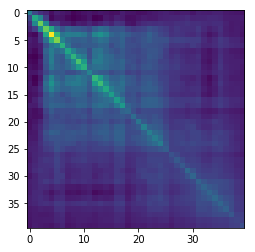

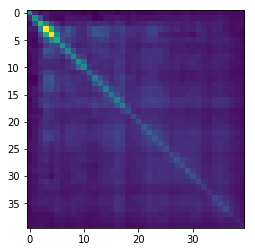

In [75]:
import numpy as np

plt.figure()
plt.imshow(np.cov(np.log(E)))

plt.figure()
plt.imshow(np.cov(np.log(PCEN)))

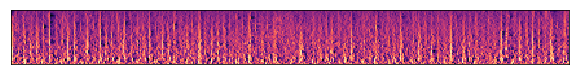

In [95]:
plt.figure(figsize=(10, 1))
librosa.display.specshow(PCEN)

In [99]:
G_list[3].shape

(17240,)